In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Helper functions and model


In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
def train(epoch, models, log=None, noise=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        if noise:
            noised = add_noise(data, mode=noise).cuda(0)
        else:
            noised = data.clone().cuda(0)

        data = data.cuda(0)
        for model in models.values():
            model.cuda(0)
            model.optim.zero_grad()
            output = model(noised)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None, noise=False):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    latent_layers = {k: [] for k in models}
    labels = []
    with torch.no_grad():
        for data, l in loader:
            if noise:
                noised = add_noise(data, mode=noise).cuda(0)
            else:
                noised = data.clone().cuda(0)
            
            data = data.cuda(0)
            output = {k: m.cuda(0)(noised) for k, m in models.items()}
            labels.append(l)
            
            for k, m in models.items():
                latent_layers[k].append(m.cuda(0).E(data.view(-1, 28*28)))
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)
    return (latent_layers, labels)

In [0]:
class Encoder(nn.Module):
    def __init__(self, latent_size=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_size=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

class AE(nn.Module):
    def __init__(self, latent_size=2, loss_fn=F.mse_loss, lr=0.0002, l2=0.):
        super(AE, self).__init__()

        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, x):
        x = x.cuda(0)
        with torch.no_grad():
            return self.D(x)

    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

#Visualization of latent representation of MNIST numbers


Train models

In [0]:
models = {'2': AE(latent_size=2), '32': AE(latent_size=32)}

In [0]:
for epoch in range(1, 41):
    train(epoch=epoch, models=models)
    latent_layers, labels = test(models, test_loader)

Train Epoch: 1 [00000/60000] 2: 1.102289 32: 1.023802
Train Epoch: 1 [30000/60000] 2: 1.023553 32: 0.407807
Train Epoch: 1 [60000/60000] 2: 0.951044 32: 0.291541
Test set:
2: loss: 0.9518
32: loss: 0.2943

Train Epoch: 2 [00000/60000] 2: 0.951383 32: 0.298558
Train Epoch: 2 [30000/60000] 2: 0.866818 32: 0.262479
Train Epoch: 2 [60000/60000] 2: 0.780984 32: 0.258070
Test set:
2: loss: 0.7810
32: loss: 0.2541

Train Epoch: 3 [00000/60000] 2: 0.783360 32: 0.259713
Train Epoch: 3 [30000/60000] 2: 0.700634 32: 0.245826
Train Epoch: 3 [60000/60000] 2: 0.630438 32: 0.225192
Test set:
2: loss: 0.6315
32: loss: 0.2283

Train Epoch: 4 [00000/60000] 2: 0.633855 32: 0.229581
Train Epoch: 4 [30000/60000] 2: 0.574208 32: 0.221715
Train Epoch: 4 [60000/60000] 2: 0.522700 32: 0.203084
Test set:
2: loss: 0.5256
32: loss: 0.2063

Train Epoch: 5 [00000/60000] 2: 0.520213 32: 0.200508
Train Epoch: 5 [30000/60000] 2: 0.484845 32: 0.196082
Train Epoch: 5 [60000/60000] 2: 0.452315 32: 0.191679
Test set:
2: l

Visualization of 2 dimensional representation and 32 dimensional with t-SNE convertion


In [0]:
latent_data_2 = np.concatenate((latent_layers['2'][0].cpu(), latent_layers['2'][1].cpu()), axis=0)
latent_data_32 = np.concatenate((latent_layers['32'][0].cpu(), latent_layers['32'][1].cpu()), axis=0)
for i in range(2, 10):
    latent_data_2 = np.concatenate((latent_data_2, latent_layers['2'][i].cpu()), axis=0)
    latent_data_32 = np.concatenate((latent_data_32, latent_layers['32'][i].cpu()), axis=0)
    
colors = []
for i in range(10):
    colors += labels[i].cpu()

In [0]:
latent_data_32 = TSNE(2).fit_transform(latent_data_32)

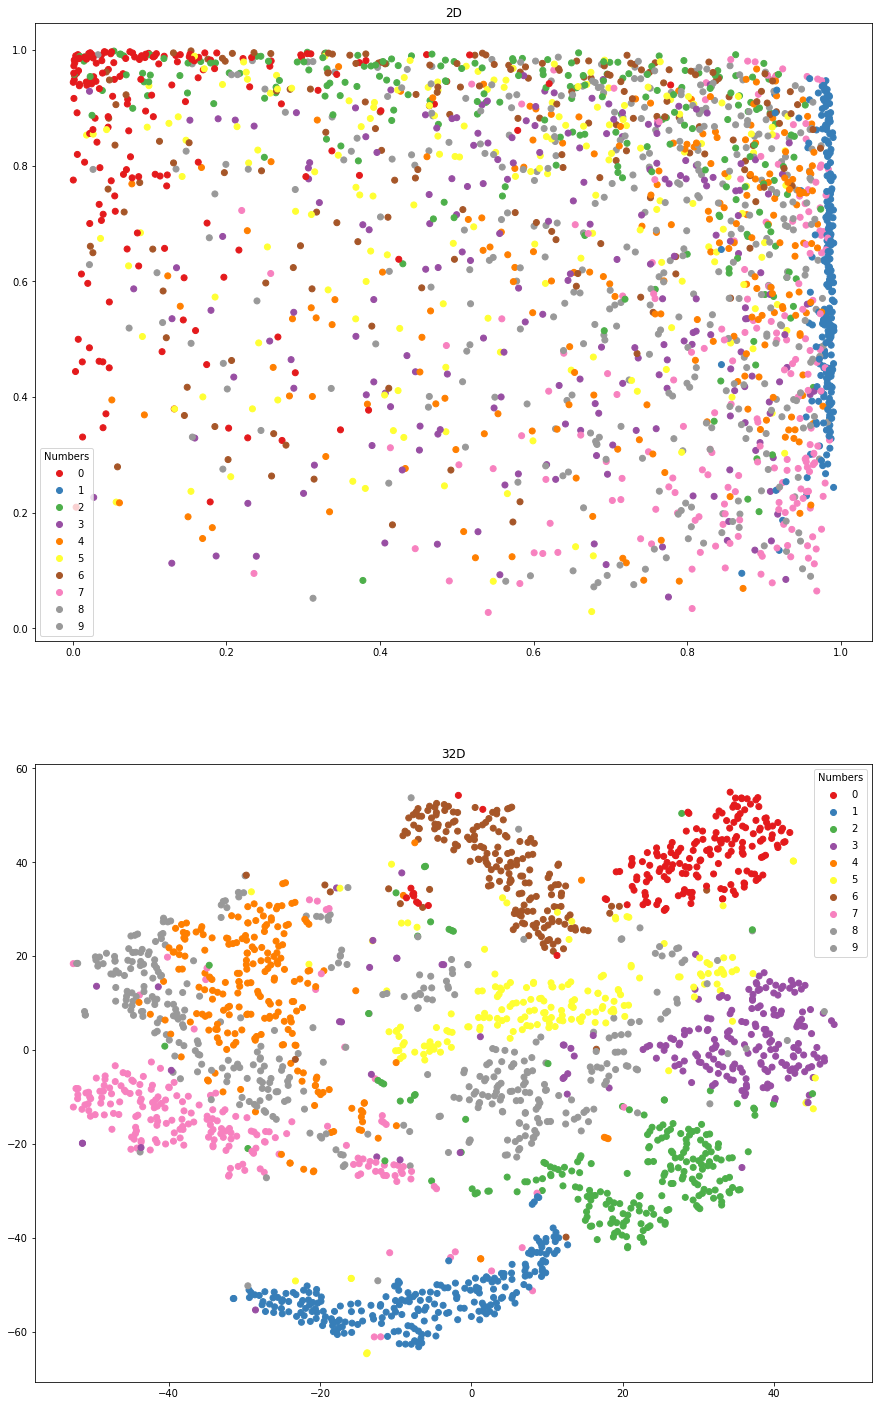

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 25))

scatter1 = ax1.scatter(latent_data_2[:, 0], latent_data_2[:, 1], c=colors, cmap='Set1')
ax1.legend(*scatter1.legend_elements(), title='Numbers')
ax1.set_title('2D')

scatter2 = ax2.scatter(latent_data_32[:, 0], latent_data_32[:, 1], c=colors, cmap='Set1')
ax2.legend(*scatter2.legend_elements(), title='Numbers')
ax2.set_title('32D')

sns.set_style('dark')
plt.show()


#Using Autoencoder to denoise images

In [0]:
def add_noise(data, mode='gaussian', mean=0., std=0.6):
    """
    Add noise to a nput data
    Arguments:
    data: data to add a noise to

    mode: ['gaussian', 'mirror']
        How to add noise. Gaussian- add Gaussian noise to an images, 
        mirror- flip random piece of an image.

    mean: mean of normal distribution for Gaussian noise
    
    std: standard deviation of normal distribution for Gaussian noise         
    """
    if mode == 'gaussian':
        noised_data = data + torch.normal(mean=mean, std=std, size=(28, 28))
    elif mode == 'mirror':
        noised_data = data.clone()
        for i in range(len(data)):
            sample = noised_data[i]
            x_low = np.random.randint(6, 14)
            x_high = np.random.randint(x_low, 27)
            y_low = np.random.randint(6, 14)
            y_high = np.random.randint(y_low, 27)
            piece_to_flip = sample[:, y_low:y_high, x_low:x_high]
            noised_data[i, :, y_low:y_high, x_low:x_high] = torch.flip(piece_to_flip, (0,1))
    return noised_data

Observe original data and noised one

Original data:



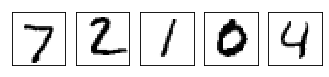

With Gaussian noise:


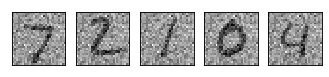

With mirrored pieces:


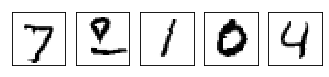

In [0]:
for data, _ in test_loader:
    gnoised_data = add_noise(data, mode='gaussian')
    mnoised_data = add_noise(data, mode='mirror')
    break

print('Original data:')
plot_mnist(data[:5], (1,5))
print('With Gaussian noise:')
plot_mnist(gnoised_data[:5], (1,5))
print('With mirrored pieces:')
plot_mnist(mnoised_data[:5], (1,5))

Train models on noised data

In [0]:
gauss_model = {'gaussian': AE(latent_size=32)}
mirror_model = {'mirrored': AE(latent_size=32)}

EPOCHS = 40
for epoch in range(1, EPOCHS+1):
    train(epoch, gauss_model, noise='gaussian')
    test(gauss_model, test_loader, noise='gaussian')

    train(epoch, mirror_model, noise='mirror')
    test(mirror_model, test_loader, noise='mirror')

Train Epoch: 1 [00000/60000] gaussian: 1.027346
Train Epoch: 1 [30000/60000] gaussian: 0.414164
Train Epoch: 1 [60000/60000] gaussian: 0.297605
Test set:
gaussian: loss: 0.2927

Train Epoch: 1 [00000/60000] mirrored: 1.016028
Train Epoch: 1 [30000/60000] mirrored: 0.391331
Train Epoch: 1 [60000/60000] mirrored: 0.287003
Test set:
mirrored: loss: 0.2876

Train Epoch: 2 [00000/60000] gaussian: 0.293386
Train Epoch: 2 [30000/60000] gaussian: 0.276202
Train Epoch: 2 [60000/60000] gaussian: 0.256574
Test set:
gaussian: loss: 0.2643

Train Epoch: 2 [00000/60000] mirrored: 0.283707
Train Epoch: 2 [30000/60000] mirrored: 0.272292
Train Epoch: 2 [60000/60000] mirrored: 0.264862
Test set:
mirrored: loss: 0.2603

Train Epoch: 3 [00000/60000] gaussian: 0.271441
Train Epoch: 3 [30000/60000] gaussian: 0.258018
Train Epoch: 3 [60000/60000] gaussian: 0.242247
Test set:
gaussian: loss: 0.2422

Train Epoch: 3 [00000/60000] mirrored: 0.254714
Train Epoch: 3 [30000/60000] mirrored: 0.255408
Train Epoch: 3

Look at how models denoise input images


After denoising Gaussian noised images:


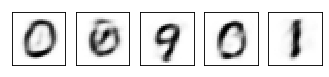

After reconstruction of partly mirrored images:


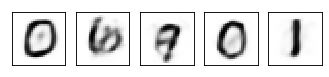

In [0]:
denoised_output_gauss = gauss_model['gaussian'](gnoised_data.cuda(0)).reshape((200, 1, 28, 28)).cpu().detach().numpy()
denoised_output_mirror = mirror_model['mirrored'](mnoised_data.cuda(0)).reshape((200, 1, 28, 28)).cpu().detach().numpy()


print('After denoising Gaussian noised images:')
plot_mnist(denoised_output_gauss[10:15], (1,5))
print('After reconstruction of partly mirrored images:')
plot_mnist(denoised_output_mirror[10:15], (1,5))

Also we can look at visualization of weights for the Encoder part of AE.

In [0]:
weights_g = list(gauss_model['gaussian'].E.parameters())
weights_m = list(mirror_model['mirrored'].E.parameters())

Weights of an encoder in the model trained on data with Gaussian noise:


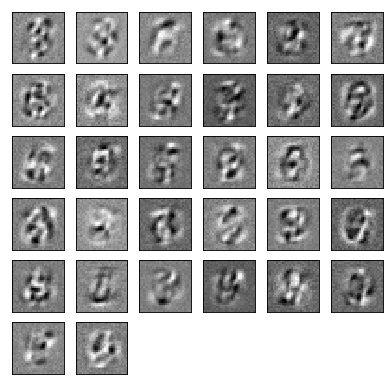

Weights of an encoder in the second model:


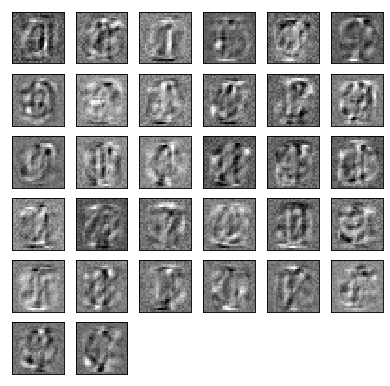

In [0]:
print('Weights of an encoder in the model trained on data with Gaussian noise:')
plot_mnist(weights_g[0].cpu().detach().numpy().reshape(-1, 1, 28, 28), (6, 6))
print('Weights of an encoder in the second model:')
plot_mnist(weights_m[0].cpu().detach().numpy().reshape(-1, 1, 28, 28), (6, 6))